<a href="https://colab.research.google.com/github/tirals88/Deep-Learning-from-Scratch/blob/main/1%EA%B6%8C_5%EC%9E%A5_(2)_%EC%98%A4%EC%B0%A8%EC%97%AD%EC%A0%84%ED%8C%8C%EB%B2%95_%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#드라이브연동
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
cd '/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch05'

/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch05


In [39]:
import numpy as np
import matplotlib.pyplot as plt

# 코드의 전체 그림

- 전체 : 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 한다. 신경망은 아래 4단계로 수행이 된다.

- 1단계 [ 미니배치 ] : 훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라고 하며, 미니배치의 손실 함수를 줄이는 것이 목표이다.

- 2단계 [ 기울기 산출 ] : 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.

- 3단계 [ 매개변수 갱신 ] : 가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

- 4단계 : [ 반복 ] : 1~3단계를 반복한다.

이 코드에서는 'numerical gradient'와 'backpropagation'모두를 구현하였다.

In [42]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

from common.layers import *   # 1권 5장 (1)에 코드 정리
from common.gradient import numerical_gradient # 1권 4장 (2)에 코드 정리
from collections import OrderedDict

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size,
               weight_init_std = 0.01):
  
    # 가중치 초기화

    self.params = {}
    self.params['W1'] = weight_init_std * \
    np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * \
    np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    # 계층 생성

    self.layers = OrderedDict()
    self.layers['Affine1'] = \
    Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = \
    Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  # x : input data / t : label data

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis = 1)
    if t.ndimt != 1:
      t = np.argmax(t, axis = 1)

    accuracy = np.sum(y == t) / float(x.shape[0])

    return accuracy

  # x : input data / t : label data

  def numerical_gradient(self, x, t):
    loss_w = lambda W : self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

  def gradient(self, x, t):
    # 순전파
    self.loss(x, t)

    # 역전파
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    #결과 저장
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].dW
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].dW

    return grads

 - 위와 같이 기울기를 구하는 방법은 수치 미분을 써서 구하는 방법과 해석적으로 수식을 풀어 구하는 오차역전파법이 있다.

 1. 먼저 수치 미분의 이점은 구현이 쉬워 버그가 숨어있기 어렵다. 하지만 속도가 느리므로 효율이 떨어지게 된다.

 2. 다음으로 오차역전파법은 속도가 수치 미분의 방식보다 빠른 것이 이점이다. 하지만 반대로 구현이 복잡하셔 실수가 종종 생기곤 한다.

 3. 이를 위해 수치 미분은 학습에 사용이 되기 보다는 오차역전파법의 결과를 비교하여 제대로 구현하였는지 검증의 역할 **Gradient check**로 사용되고는 한다.

In [52]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

#데이터 읽기

(x_train, t_train), (x_test, t_test) = \
load_mnist(normalize = True, one_hot_label = True)

network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

x_batch = x_train[:5]
t_batch = t_train[:5]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.

for key in grad_numerical.keys():
  diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]))
  print(key + ":" + str(diff))

W1:5.159594178062389e-07
b1:6.905133888036384e-06
W2:4.677886708845878e-09
b2:9.99207962412707e-08


위와 같은 결과를 보면 수치 미분과 오차역전파법으로 구한 기울기의 차이가 매우 작음을 알 수 있다.

**결과 오차가 0이 되는 일은 드물다. 이는 컴퓨터의 부동소수점의 한계 때문에 0에 아주 가까운 값으로 나오기 때문이다.**

In [70]:
# 학습 구현

import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
load_mnist(normalize = True, one_hot_label = True)
network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # 오차역전파법으로 기울기 계산
  grad = network.gradient(x_batch, t_batch)

  #갱신
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % (iter_per_epoch  / 4 ) == 0 :
  #if i % 10 == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("iters_num : ", i, ", train_acc : ", train_acc, ",  test_acc : ", test_acc)

iters_num :  0 , train_acc :  0.15205 ,  test_acc :  0.1515
iters_num :  150 , train_acc :  0.8012 ,  test_acc :  0.8069
iters_num :  300 , train_acc :  0.8754333333333333 ,  test_acc :  0.8807
iters_num :  450 , train_acc :  0.8951 ,  test_acc :  0.8981
iters_num :  600 , train_acc :  0.9050333333333334 ,  test_acc :  0.9071
iters_num :  750 , train_acc :  0.91115 ,  test_acc :  0.9142
iters_num :  900 , train_acc :  0.9164833333333333 ,  test_acc :  0.9187
iters_num :  1050 , train_acc :  0.9167333333333333 ,  test_acc :  0.9182
iters_num :  1200 , train_acc :  0.92385 ,  test_acc :  0.9251
iters_num :  1350 , train_acc :  0.9277166666666666 ,  test_acc :  0.9309
iters_num :  1500 , train_acc :  0.9316666666666666 ,  test_acc :  0.9328
iters_num :  1650 , train_acc :  0.9341666666666667 ,  test_acc :  0.9346
iters_num :  1800 , train_acc :  0.9377833333333333 ,  test_acc :  0.9371
iters_num :  1950 , train_acc :  0.9384666666666667 ,  test_acc :  0.9379
iters_num :  2100 , train_acc 

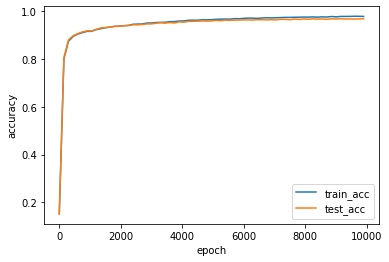

In [71]:
# batch_size = 100, iters_num = 10000
axis_y2 = train_acc_list
axis_y3 = test_acc_list

axis_x = np.arange(len(train_acc_list)) * 150
plt.plot(axis_x, axis_y2, label = 'train_acc')
plt.plot(axis_x, axis_y3, label = 'test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

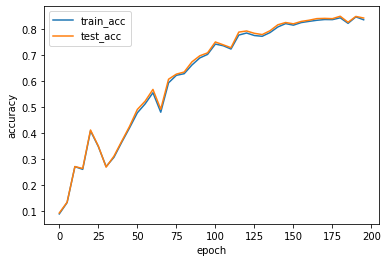

In [75]:
# batch_size = 100, iters_num = 200
axis_y2 = train_acc_list
axis_y3 = test_acc_list

axis_x = np.arange(len(train_acc_list)) * 5
plt.plot(axis_x, axis_y2, label = 'train_acc')
plt.plot(axis_x, axis_y3, label = 'test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()